In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

In [4]:
class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 9, 9).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

In [5]:
class SmallDNN(nn.Module):
    def __init__(self, input_dim=4*12*9*9, hidden_dim=64, output_dim=6, dropout_rate=0.2):
        super(SmallDNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.norm2 = nn.LayerNorm(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        # Skip connection projection
        self.skip_proj = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # (batch_size, 3888)
        skip = self.skip_proj(x)  # Skip connection output

        x = self.fc1(x)
        x = self.norm1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.norm2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x + skip  # Skip connection

0 start!


Epoch 1/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 151.30it/s]



Epoch [1/100], Train Loss: 76.8616, Train Accuracy: 68.38%, Val Loss: 69.8962, Val Accuracy: 65.48%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 149.36it/s]



Epoch [2/100], Train Loss: 68.9731, Train Accuracy: 73.10%, Val Loss: 128.0456, Val Accuracy: 67.95%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 151.29it/s]



Epoch [3/100], Train Loss: 65.9735, Train Accuracy: 74.41%, Val Loss: 47.4816, Val Accuracy: 74.42%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 155.28it/s]



Epoch [4/100], Train Loss: 65.4628, Train Accuracy: 75.13%, Val Loss: 70.1478, Val Accuracy: 69.01%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 152.81it/s]



Epoch [5/100], Train Loss: 68.3928, Train Accuracy: 75.35%, Val Loss: 51.6375, Val Accuracy: 73.81%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 150.93it/s]



Epoch [6/100], Train Loss: 66.5973, Train Accuracy: 75.64%, Val Loss: 126.8038, Val Accuracy: 60.91%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 151.90it/s]



Epoch [7/100], Train Loss: 67.5793, Train Accuracy: 75.64%, Val Loss: 69.8095, Val Accuracy: 71.94%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 153.54it/s]



Epoch [8/100], Train Loss: 65.1353, Train Accuracy: 76.19%, Val Loss: 48.7959, Val Accuracy: 75.11%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 936/936 [00:06<00:00, 153.16it/s]



Epoch [9/100], Train Loss: 65.7453, Train Accuracy: 76.36%, Val Loss: 47.4646, Val Accuracy: 76.26%



Epoch 10/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 151.65it/s]



Epoch [10/100], Train Loss: 65.8214, Train Accuracy: 76.36%, Val Loss: 80.7055, Val Accuracy: 69.64%



Epoch 11/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.04it/s]



Epoch [11/100], Train Loss: 65.9802, Train Accuracy: 76.54%, Val Loss: 41.1295, Val Accuracy: 78.73%



Epoch 12/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.06it/s]



Epoch [12/100], Train Loss: 67.1480, Train Accuracy: 76.61%, Val Loss: 70.7054, Val Accuracy: 72.31%



Epoch 13/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 150.36it/s]



Epoch [13/100], Train Loss: 65.9118, Train Accuracy: 76.73%, Val Loss: 53.6255, Val Accuracy: 77.21%



Epoch 14/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 154.24it/s]



Epoch [14/100], Train Loss: 65.8042, Train Accuracy: 76.93%, Val Loss: 73.6578, Val Accuracy: 71.82%



Epoch 15/100 - Validation: 100%|████████████████████████████| 936/936 [00:05<00:00, 157.74it/s]



Epoch [15/100], Train Loss: 67.1247, Train Accuracy: 77.02%, Val Loss: 73.0664, Val Accuracy: 70.51%



Epoch 16/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 150.57it/s]



Epoch [16/100], Train Loss: 67.7368, Train Accuracy: 76.95%, Val Loss: 127.9372, Val Accuracy: 67.14%



Epoch 17/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 150.38it/s]



Epoch [17/100], Train Loss: 67.1387, Train Accuracy: 77.16%, Val Loss: 58.8041, Val Accuracy: 76.06%



Epoch 18/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 150.64it/s]



Epoch [18/100], Train Loss: 66.4749, Train Accuracy: 77.40%, Val Loss: 57.9002, Val Accuracy: 75.84%



Epoch 19/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.66it/s]



Epoch [19/100], Train Loss: 67.2048, Train Accuracy: 77.11%, Val Loss: 61.7823, Val Accuracy: 73.15%



Epoch 20/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.38it/s]



Epoch [20/100], Train Loss: 65.8670, Train Accuracy: 77.50%, Val Loss: 76.3721, Val Accuracy: 70.83%



Epoch 21/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 151.35it/s]



Epoch [21/100], Train Loss: 66.2072, Train Accuracy: 77.56%, Val Loss: 73.8266, Val Accuracy: 70.58%



Epoch 22/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 155.04it/s]



Epoch [22/100], Train Loss: 66.4739, Train Accuracy: 77.72%, Val Loss: 43.0033, Val Accuracy: 79.02%



Epoch 23/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 148.22it/s]



Epoch [23/100], Train Loss: 64.6345, Train Accuracy: 77.97%, Val Loss: 93.6465, Val Accuracy: 68.79%



Epoch 24/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 145.35it/s]



Epoch [24/100], Train Loss: 65.3423, Train Accuracy: 77.94%, Val Loss: 65.7420, Val Accuracy: 73.73%



Epoch 25/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 155.26it/s]



Epoch [25/100], Train Loss: 66.2463, Train Accuracy: 77.82%, Val Loss: 76.2243, Val Accuracy: 71.67%



Epoch 26/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 151.07it/s]



Epoch [26/100], Train Loss: 63.8498, Train Accuracy: 78.15%, Val Loss: 68.4768, Val Accuracy: 75.18%



Epoch 27/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.43it/s]



Epoch [27/100], Train Loss: 61.3282, Train Accuracy: 78.46%, Val Loss: 73.6001, Val Accuracy: 71.65%



Epoch 28/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 152.33it/s]



Epoch [28/100], Train Loss: 63.5018, Train Accuracy: 78.26%, Val Loss: 54.8926, Val Accuracy: 75.64%



Epoch 29/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 151.06it/s]



Epoch [29/100], Train Loss: 64.0945, Train Accuracy: 78.21%, Val Loss: 65.6622, Val Accuracy: 73.73%



Epoch 30/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 154.93it/s]



Epoch [30/100], Train Loss: 63.8294, Train Accuracy: 78.49%, Val Loss: 60.9622, Val Accuracy: 74.86%



Epoch 31/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.93it/s]



Epoch [31/100], Train Loss: 62.9454, Train Accuracy: 78.72%, Val Loss: 55.4225, Val Accuracy: 78.43%



Epoch 32/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 150.62it/s]



Epoch [32/100], Train Loss: 64.8475, Train Accuracy: 78.51%, Val Loss: 119.3892, Val Accuracy: 66.34%



Epoch 33/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 150.76it/s]



Epoch [33/100], Train Loss: 64.4793, Train Accuracy: 78.69%, Val Loss: 73.3819, Val Accuracy: 72.09%



Epoch 34/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 155.39it/s]



Epoch [34/100], Train Loss: 63.0069, Train Accuracy: 78.76%, Val Loss: 72.2884, Val Accuracy: 75.50%



Epoch 35/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 155.22it/s]



Epoch [35/100], Train Loss: 63.8359, Train Accuracy: 79.07%, Val Loss: 64.2333, Val Accuracy: 75.92%



Epoch 36/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 154.03it/s]



Epoch [36/100], Train Loss: 68.2272, Train Accuracy: 78.66%, Val Loss: 73.1220, Val Accuracy: 75.29%



Epoch 37/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.57it/s]



Epoch [37/100], Train Loss: 63.7026, Train Accuracy: 79.16%, Val Loss: 110.5857, Val Accuracy: 67.05%



Epoch 38/100 - Validation: 100%|████████████████████████████| 936/936 [00:05<00:00, 156.27it/s]



Epoch [38/100], Train Loss: 62.1314, Train Accuracy: 79.33%, Val Loss: 90.0776, Val Accuracy: 71.10%



Epoch 39/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 154.59it/s]



Epoch [39/100], Train Loss: 66.2444, Train Accuracy: 79.08%, Val Loss: 63.0216, Val Accuracy: 79.26%



Epoch 40/100 - Validation: 100%|████████████████████████████| 936/936 [00:06<00:00, 153.43it/s]



Epoch [40/100], Train Loss: 63.6936, Train Accuracy: 79.55%, Val Loss: 79.0187, Val Accuracy: 72.72%



Epoch 41/100 - Validation: 100%|████████████████████████████| 936/936 [00:05<00:00, 158.44it/s]



Epoch [41/100], Train Loss: 60.6257, Train Accuracy: 79.68%, Val Loss: 74.0608, Val Accuracy: 73.97%

Early stopping triggered. Training stopped.


Evaluation Progress: 100%|██████████████████████████████████| 936/936 [00:05<00:00, 159.20it/s]


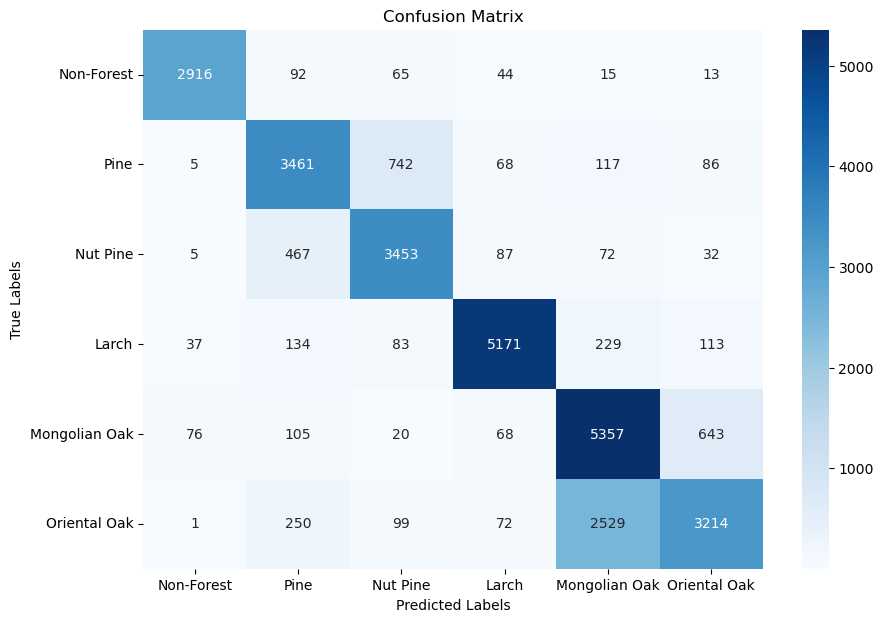

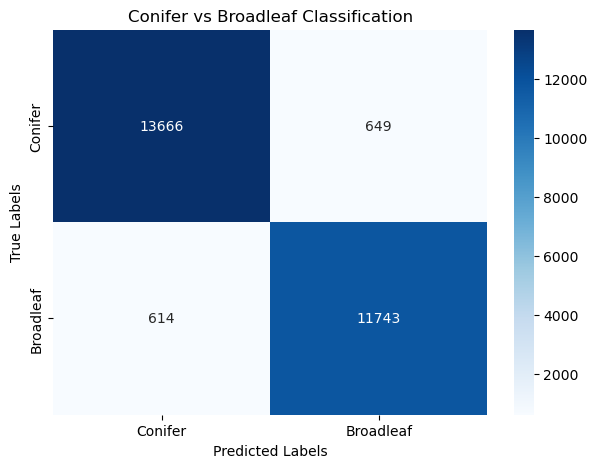

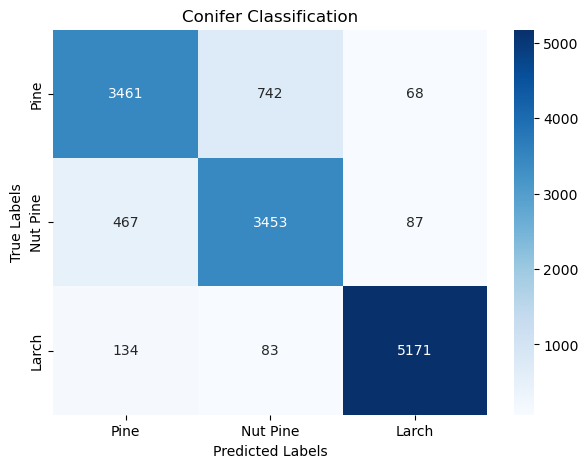

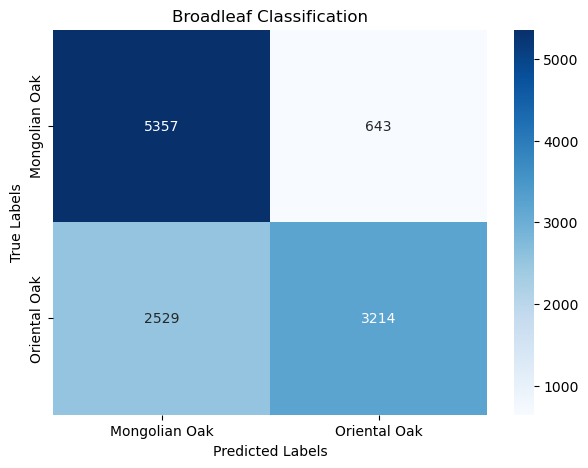

Finished Fold 1/5. Cleared memory.
1 start!


Epoch 1/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 154.06it/s]



Epoch [1/100], Train Loss: 70.9599, Train Accuracy: 68.05%, Val Loss: 84.0259, Val Accuracy: 64.81%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 154.84it/s]



Epoch [2/100], Train Loss: 67.4745, Train Accuracy: 72.85%, Val Loss: 111.1777, Val Accuracy: 63.41%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 154.09it/s]



Epoch [3/100], Train Loss: 64.9101, Train Accuracy: 74.39%, Val Loss: 99.7298, Val Accuracy: 72.24%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 151.37it/s]



Epoch [4/100], Train Loss: 65.6970, Train Accuracy: 74.97%, Val Loss: 88.8640, Val Accuracy: 68.13%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 153.76it/s]



Epoch [5/100], Train Loss: 64.1665, Train Accuracy: 75.43%, Val Loss: 109.1493, Val Accuracy: 62.83%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 153.30it/s]



Epoch [6/100], Train Loss: 65.0132, Train Accuracy: 75.90%, Val Loss: 72.3830, Val Accuracy: 71.67%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 151.98it/s]



Epoch [7/100], Train Loss: 66.4435, Train Accuracy: 75.93%, Val Loss: 96.1624, Val Accuracy: 71.57%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 151.69it/s]



Epoch [8/100], Train Loss: 65.9282, Train Accuracy: 76.24%, Val Loss: 185.5159, Val Accuracy: 55.60%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 784/784 [00:05<00:00, 152.69it/s]



Epoch [9/100], Train Loss: 65.6532, Train Accuracy: 76.45%, Val Loss: 94.4292, Val Accuracy: 74.62%



Epoch 10/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 151.09it/s]



Epoch [10/100], Train Loss: 63.6322, Train Accuracy: 76.73%, Val Loss: 97.3532, Val Accuracy: 70.88%



Epoch 11/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.32it/s]



Epoch [11/100], Train Loss: 66.7642, Train Accuracy: 76.51%, Val Loss: 79.2128, Val Accuracy: 73.93%



Epoch 12/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 150.03it/s]



Epoch [12/100], Train Loss: 66.9501, Train Accuracy: 76.69%, Val Loss: 113.3165, Val Accuracy: 65.80%



Epoch 13/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.72it/s]



Epoch [13/100], Train Loss: 63.3576, Train Accuracy: 77.09%, Val Loss: 68.9359, Val Accuracy: 74.45%



Epoch 14/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.50it/s]



Epoch [14/100], Train Loss: 66.4926, Train Accuracy: 76.83%, Val Loss: 131.5443, Val Accuracy: 70.96%



Epoch 15/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.34it/s]



Epoch [15/100], Train Loss: 66.4520, Train Accuracy: 77.09%, Val Loss: 80.1730, Val Accuracy: 76.16%



Epoch 16/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.74it/s]



Epoch [16/100], Train Loss: 65.9991, Train Accuracy: 77.10%, Val Loss: 74.2785, Val Accuracy: 74.65%



Epoch 17/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.46it/s]



Epoch [17/100], Train Loss: 67.2251, Train Accuracy: 77.24%, Val Loss: 87.0181, Val Accuracy: 71.10%



Epoch 18/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.57it/s]



Epoch [18/100], Train Loss: 63.8518, Train Accuracy: 77.48%, Val Loss: 80.6935, Val Accuracy: 73.69%



Epoch 19/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 154.35it/s]



Epoch [19/100], Train Loss: 65.6079, Train Accuracy: 77.42%, Val Loss: 109.9823, Val Accuracy: 68.51%



Epoch 20/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.01it/s]



Epoch [20/100], Train Loss: 63.0013, Train Accuracy: 77.46%, Val Loss: 102.1499, Val Accuracy: 71.84%



Epoch 21/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 150.72it/s]



Epoch [21/100], Train Loss: 65.8906, Train Accuracy: 77.52%, Val Loss: 117.7843, Val Accuracy: 67.86%



Epoch 22/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 154.76it/s]



Epoch [22/100], Train Loss: 66.7063, Train Accuracy: 77.24%, Val Loss: 88.4259, Val Accuracy: 76.93%



Epoch 23/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 148.62it/s]



Epoch [23/100], Train Loss: 64.3121, Train Accuracy: 77.65%, Val Loss: 90.4927, Val Accuracy: 71.66%



Epoch 24/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 150.16it/s]



Epoch [24/100], Train Loss: 67.0907, Train Accuracy: 77.41%, Val Loss: 108.1431, Val Accuracy: 68.88%



Epoch 25/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 151.55it/s]



Epoch [25/100], Train Loss: 64.9045, Train Accuracy: 77.93%, Val Loss: 81.2262, Val Accuracy: 76.70%



Epoch 26/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 150.49it/s]



Epoch [26/100], Train Loss: 68.2319, Train Accuracy: 77.57%, Val Loss: 91.0114, Val Accuracy: 76.39%



Epoch 27/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.03it/s]



Epoch [27/100], Train Loss: 65.4310, Train Accuracy: 78.02%, Val Loss: 94.7803, Val Accuracy: 72.97%



Epoch 28/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 155.81it/s]



Epoch [28/100], Train Loss: 66.2362, Train Accuracy: 77.88%, Val Loss: 97.2378, Val Accuracy: 70.45%



Epoch 29/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.94it/s]



Epoch [29/100], Train Loss: 66.2395, Train Accuracy: 78.05%, Val Loss: 72.6969, Val Accuracy: 78.20%



Epoch 30/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 154.45it/s]



Epoch [30/100], Train Loss: 63.8872, Train Accuracy: 78.22%, Val Loss: 83.4995, Val Accuracy: 73.56%



Epoch 31/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.24it/s]



Epoch [31/100], Train Loss: 65.1294, Train Accuracy: 78.10%, Val Loss: 120.9120, Val Accuracy: 70.63%



Epoch 32/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.28it/s]



Epoch [32/100], Train Loss: 66.4807, Train Accuracy: 77.99%, Val Loss: 84.7327, Val Accuracy: 77.43%



Epoch 33/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.65it/s]



Epoch [33/100], Train Loss: 62.0080, Train Accuracy: 78.61%, Val Loss: 115.8038, Val Accuracy: 72.48%



Epoch 34/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.66it/s]



Epoch [34/100], Train Loss: 63.6916, Train Accuracy: 78.63%, Val Loss: 111.2745, Val Accuracy: 66.90%



Epoch 35/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.78it/s]



Epoch [35/100], Train Loss: 64.7628, Train Accuracy: 78.46%, Val Loss: 70.7622, Val Accuracy: 77.26%



Epoch 36/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 152.81it/s]



Epoch [36/100], Train Loss: 63.9519, Train Accuracy: 78.41%, Val Loss: 121.8734, Val Accuracy: 72.78%



Epoch 37/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.24it/s]



Epoch [37/100], Train Loss: 63.6624, Train Accuracy: 78.78%, Val Loss: 88.5395, Val Accuracy: 72.88%



Epoch 38/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 153.38it/s]



Epoch [38/100], Train Loss: 66.2405, Train Accuracy: 78.39%, Val Loss: 76.3399, Val Accuracy: 77.21%



Epoch 39/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 151.87it/s]



Epoch [39/100], Train Loss: 62.6476, Train Accuracy: 78.83%, Val Loss: 92.3476, Val Accuracy: 76.43%



Epoch 40/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 154.31it/s]



Epoch [40/100], Train Loss: 62.4942, Train Accuracy: 79.05%, Val Loss: 111.0572, Val Accuracy: 70.44%



Epoch 41/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 154.47it/s]



Epoch [41/100], Train Loss: 63.5225, Train Accuracy: 78.77%, Val Loss: 92.2103, Val Accuracy: 73.51%



Epoch 42/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 150.67it/s]



Epoch [42/100], Train Loss: 63.8322, Train Accuracy: 78.84%, Val Loss: 152.7838, Val Accuracy: 66.22%



Epoch 43/100 - Validation: 100%|████████████████████████████| 784/784 [00:05<00:00, 154.47it/s]



Epoch [43/100], Train Loss: 60.6034, Train Accuracy: 79.29%, Val Loss: 93.8177, Val Accuracy: 75.07%

Early stopping triggered. Training stopped.


Evaluation Progress: 100%|██████████████████████████████████| 784/784 [00:05<00:00, 152.93it/s]


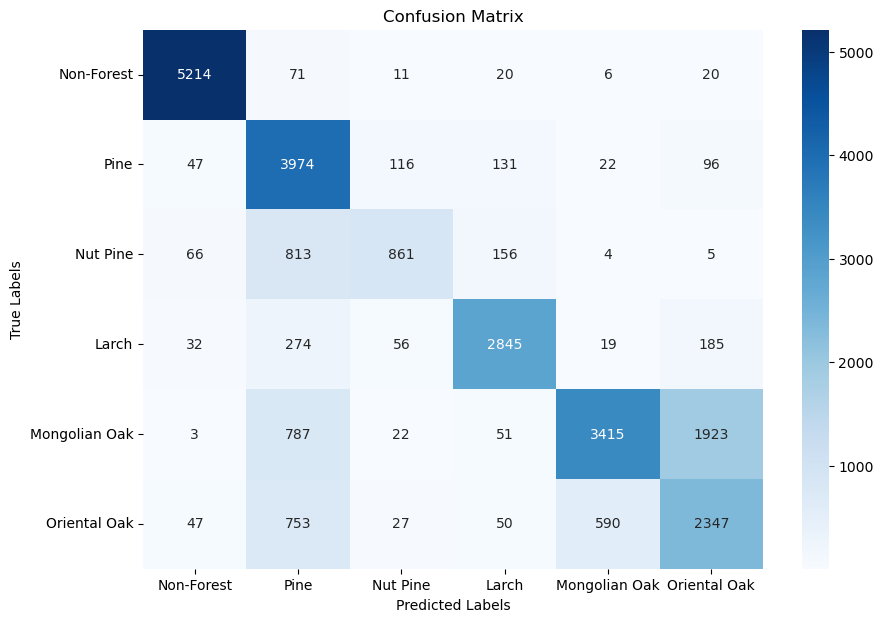

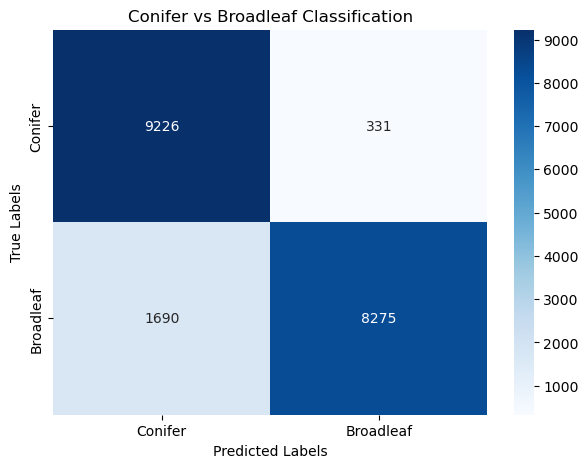

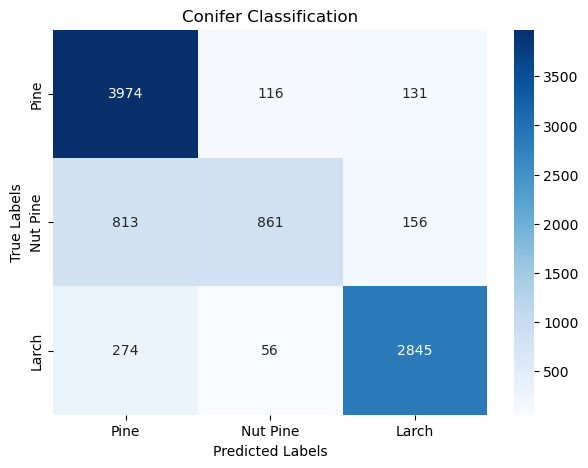

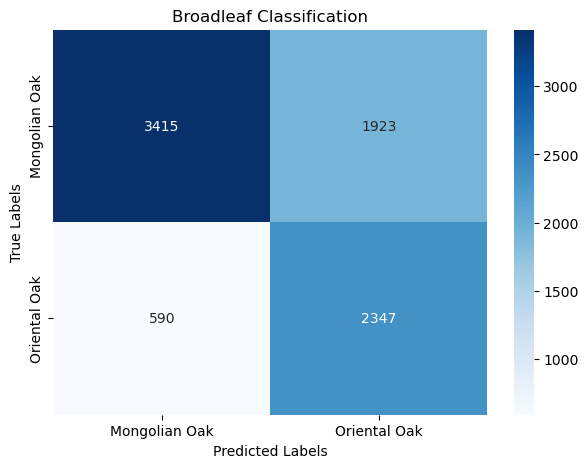

Finished Fold 2/5. Cleared memory.
2 start!


Epoch 1/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 150.41it/s]



Epoch [1/100], Train Loss: 79.2723, Train Accuracy: 67.36%, Val Loss: 59.4891, Val Accuracy: 70.68%



Epoch 2/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 150.16it/s]



Epoch [2/100], Train Loss: 69.1457, Train Accuracy: 72.17%, Val Loss: 72.2302, Val Accuracy: 73.39%



Epoch 3/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 146.18it/s]



Epoch [3/100], Train Loss: 67.0663, Train Accuracy: 73.53%, Val Loss: 62.3100, Val Accuracy: 74.21%



Epoch 4/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 145.05it/s]



Epoch [4/100], Train Loss: 67.6209, Train Accuracy: 74.25%, Val Loss: 88.6000, Val Accuracy: 73.77%



Epoch 5/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 149.63it/s]



Epoch [5/100], Train Loss: 68.2215, Train Accuracy: 74.56%, Val Loss: 51.5902, Val Accuracy: 78.15%



Epoch 6/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 134.07it/s]



Epoch [6/100], Train Loss: 67.3315, Train Accuracy: 75.02%, Val Loss: 49.3135, Val Accuracy: 79.33%



Epoch 7/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:09<00:00, 115.33it/s]



Epoch [7/100], Train Loss: 66.0163, Train Accuracy: 75.38%, Val Loss: 53.1026, Val Accuracy: 78.81%



Epoch 8/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 132.01it/s]



Epoch [8/100], Train Loss: 65.1424, Train Accuracy: 75.56%, Val Loss: 53.8781, Val Accuracy: 77.93%



Epoch 9/100 - Validation: 100%|███████████████████████████| 1053/1053 [00:07<00:00, 145.94it/s]



Epoch [9/100], Train Loss: 65.8744, Train Accuracy: 75.67%, Val Loss: 73.8858, Val Accuracy: 76.17%



Epoch 10/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 147.22it/s]



Epoch [10/100], Train Loss: 64.8318, Train Accuracy: 76.09%, Val Loss: 57.6998, Val Accuracy: 74.96%



Epoch 11/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 144.49it/s]



Epoch [11/100], Train Loss: 68.7208, Train Accuracy: 75.71%, Val Loss: 89.1473, Val Accuracy: 68.95%



Epoch 12/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 117.70it/s]



Epoch [12/100], Train Loss: 66.6238, Train Accuracy: 76.18%, Val Loss: 108.8128, Val Accuracy: 68.36%



Epoch 13/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 136.38it/s]



Epoch [13/100], Train Loss: 72.0914, Train Accuracy: 75.85%, Val Loss: 116.8739, Val Accuracy: 64.61%



Epoch 14/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 117.19it/s]



Epoch [14/100], Train Loss: 68.4042, Train Accuracy: 76.40%, Val Loss: 49.6761, Val Accuracy: 81.43%



Epoch 15/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 124.13it/s]



Epoch [15/100], Train Loss: 66.8411, Train Accuracy: 76.49%, Val Loss: 54.3260, Val Accuracy: 78.84%



Epoch 16/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 122.83it/s]



Epoch [16/100], Train Loss: 65.9069, Train Accuracy: 76.52%, Val Loss: 65.0493, Val Accuracy: 77.47%



Epoch 17/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 133.21it/s]



Epoch [17/100], Train Loss: 68.1947, Train Accuracy: 76.69%, Val Loss: 83.7218, Val Accuracy: 70.07%



Epoch 18/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 122.18it/s]



Epoch [18/100], Train Loss: 67.5923, Train Accuracy: 76.47%, Val Loss: 49.3584, Val Accuracy: 79.52%



Epoch 19/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 122.36it/s]



Epoch [19/100], Train Loss: 68.1915, Train Accuracy: 76.56%, Val Loss: 88.8228, Val Accuracy: 70.01%



Epoch 20/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 127.27it/s]



Epoch [20/100], Train Loss: 64.4572, Train Accuracy: 76.95%, Val Loss: 52.0851, Val Accuracy: 79.91%



Epoch 21/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 122.90it/s]



Epoch [21/100], Train Loss: 64.8328, Train Accuracy: 76.98%, Val Loss: 88.6587, Val Accuracy: 70.44%



Epoch 22/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 120.71it/s]



Epoch [22/100], Train Loss: 65.8982, Train Accuracy: 77.02%, Val Loss: 81.3752, Val Accuracy: 76.19%



Epoch 23/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 121.71it/s]



Epoch [23/100], Train Loss: 67.5565, Train Accuracy: 77.00%, Val Loss: 70.4835, Val Accuracy: 76.72%



Epoch 24/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 130.48it/s]



Epoch [24/100], Train Loss: 65.6902, Train Accuracy: 77.13%, Val Loss: 58.5484, Val Accuracy: 77.70%



Epoch 25/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 118.76it/s]



Epoch [25/100], Train Loss: 67.2287, Train Accuracy: 77.03%, Val Loss: 62.7838, Val Accuracy: 77.65%



Epoch 26/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:09<00:00, 113.54it/s]



Epoch [26/100], Train Loss: 66.2771, Train Accuracy: 77.47%, Val Loss: 82.4219, Val Accuracy: 75.07%



Epoch 27/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 125.97it/s]



Epoch [27/100], Train Loss: 63.8416, Train Accuracy: 77.71%, Val Loss: 62.3743, Val Accuracy: 76.31%



Epoch 28/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 141.62it/s]



Epoch [28/100], Train Loss: 62.9705, Train Accuracy: 77.81%, Val Loss: 61.2630, Val Accuracy: 77.98%



Epoch 29/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 122.49it/s]



Epoch [29/100], Train Loss: 64.2187, Train Accuracy: 77.61%, Val Loss: 181.1223, Val Accuracy: 68.06%



Epoch 30/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:09<00:00, 113.20it/s]



Epoch [30/100], Train Loss: 64.5011, Train Accuracy: 77.79%, Val Loss: 50.8151, Val Accuracy: 81.42%



Epoch 31/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 128.97it/s]



Epoch [31/100], Train Loss: 61.3811, Train Accuracy: 78.04%, Val Loss: 98.5750, Val Accuracy: 68.11%



Epoch 32/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 149.29it/s]



Epoch [32/100], Train Loss: 66.6590, Train Accuracy: 77.52%, Val Loss: 90.3498, Val Accuracy: 72.72%



Epoch 33/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:08<00:00, 123.20it/s]



Epoch [33/100], Train Loss: 67.5209, Train Accuracy: 77.93%, Val Loss: 132.1560, Val Accuracy: 66.69%



Epoch 34/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 148.93it/s]



Epoch [34/100], Train Loss: 65.0489, Train Accuracy: 77.86%, Val Loss: 51.1757, Val Accuracy: 82.27%



Epoch 35/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 149.20it/s]



Epoch [35/100], Train Loss: 65.8807, Train Accuracy: 78.01%, Val Loss: 80.8625, Val Accuracy: 76.44%



Epoch 36/100 - Validation: 100%|██████████████████████████| 1053/1053 [00:07<00:00, 148.13it/s]



Epoch [36/100], Train Loss: 63.1336, Train Accuracy: 78.36%, Val Loss: 71.8303, Val Accuracy: 73.91%

Early stopping triggered. Training stopped.


Evaluation Progress: 100%|████████████████████████████████| 1053/1053 [00:06<00:00, 150.54it/s]


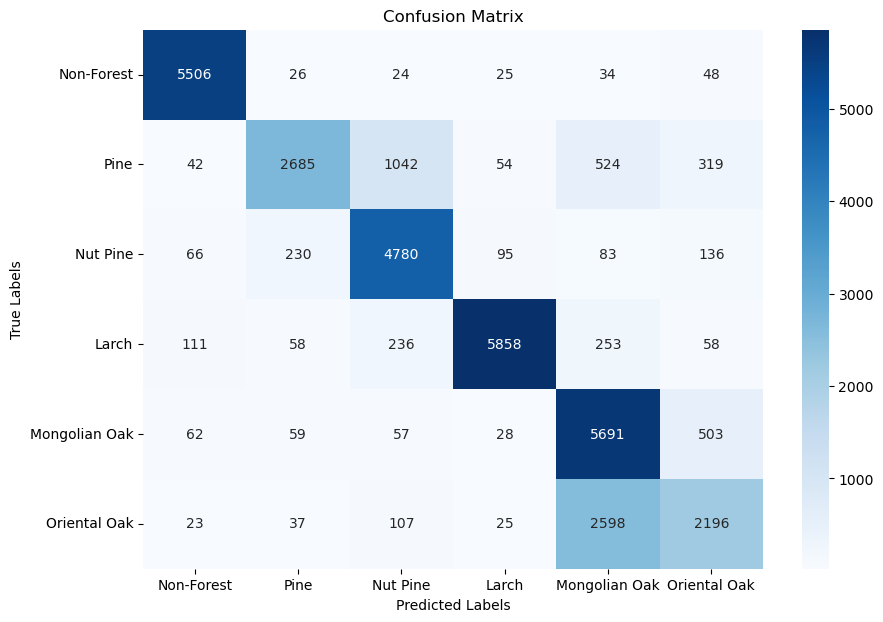

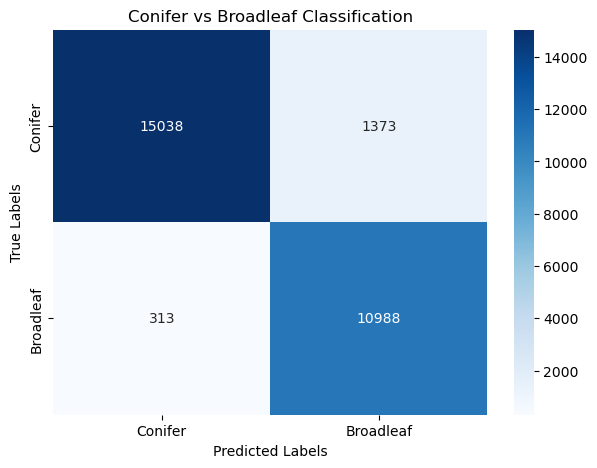

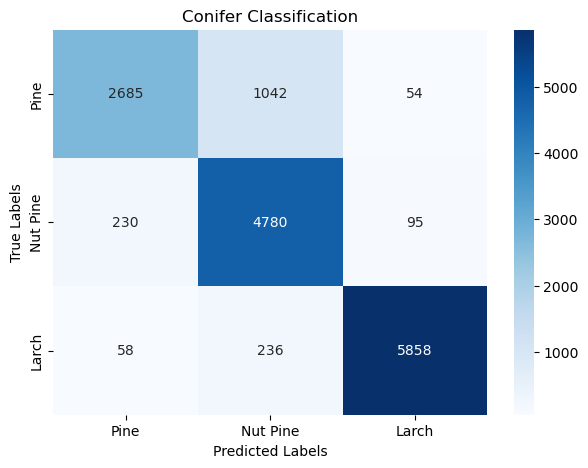

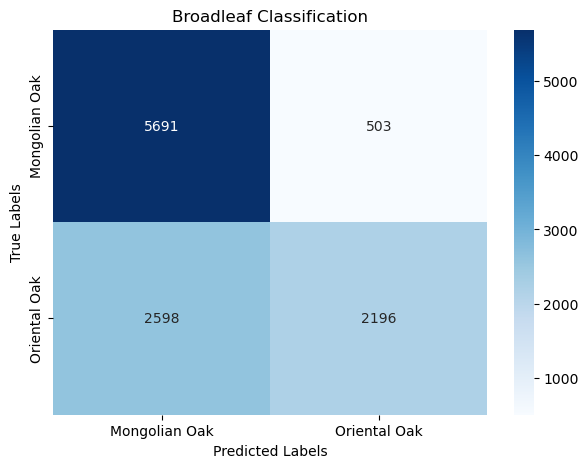

Finished Fold 3/5. Cleared memory.
3 start!


Epoch 1/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 148.90it/s]



Epoch [1/100], Train Loss: 75.9113, Train Accuracy: 67.58%, Val Loss: 49.7019, Val Accuracy: 76.19%



Epoch 2/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 144.13it/s]



Epoch [2/100], Train Loss: 68.0406, Train Accuracy: 72.65%, Val Loss: 63.1205, Val Accuracy: 73.65%



Epoch 3/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:07<00:00, 141.60it/s]



Epoch [3/100], Train Loss: 63.5387, Train Accuracy: 74.11%, Val Loss: 58.5460, Val Accuracy: 75.42%



Epoch 4/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 148.12it/s]



Epoch [4/100], Train Loss: 64.9154, Train Accuracy: 74.53%, Val Loss: 45.3625, Val Accuracy: 77.70%



Epoch 5/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 145.64it/s]



Epoch [5/100], Train Loss: 62.8639, Train Accuracy: 75.01%, Val Loss: 152.6856, Val Accuracy: 68.16%



Epoch 6/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 148.37it/s]



Epoch [6/100], Train Loss: 64.0108, Train Accuracy: 75.31%, Val Loss: 112.2874, Val Accuracy: 69.54%



Epoch 7/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 144.90it/s]



Epoch [7/100], Train Loss: 65.7546, Train Accuracy: 75.35%, Val Loss: 100.7750, Val Accuracy: 74.66%



Epoch 8/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 146.54it/s]



Epoch [8/100], Train Loss: 65.1039, Train Accuracy: 75.66%, Val Loss: 54.5914, Val Accuracy: 77.07%



Epoch 9/100 - Validation: 100%|███████████████████████████| 1001/1001 [00:06<00:00, 149.25it/s]



Epoch [9/100], Train Loss: 66.3068, Train Accuracy: 75.84%, Val Loss: 75.1830, Val Accuracy: 73.29%



Epoch 10/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 148.08it/s]



Epoch [10/100], Train Loss: 65.9965, Train Accuracy: 75.81%, Val Loss: 52.7121, Val Accuracy: 78.74%



Epoch 11/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 148.52it/s]



Epoch [11/100], Train Loss: 62.3706, Train Accuracy: 76.50%, Val Loss: 89.3753, Val Accuracy: 72.60%



Epoch 12/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 147.83it/s]



Epoch [12/100], Train Loss: 66.5687, Train Accuracy: 76.01%, Val Loss: 93.8602, Val Accuracy: 71.54%



Epoch 13/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 144.03it/s]



Epoch [13/100], Train Loss: 65.0489, Train Accuracy: 76.25%, Val Loss: 166.4619, Val Accuracy: 68.80%



Epoch 14/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 147.48it/s]



Epoch [14/100], Train Loss: 63.3791, Train Accuracy: 76.64%, Val Loss: 104.5472, Val Accuracy: 70.60%



Epoch 15/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 150.04it/s]



Epoch [15/100], Train Loss: 67.0538, Train Accuracy: 76.22%, Val Loss: 104.9963, Val Accuracy: 71.82%



Epoch 16/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 149.09it/s]



Epoch [16/100], Train Loss: 64.7415, Train Accuracy: 76.70%, Val Loss: 69.9696, Val Accuracy: 77.35%



Epoch 17/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 148.73it/s]



Epoch [17/100], Train Loss: 65.1392, Train Accuracy: 76.76%, Val Loss: 72.6626, Val Accuracy: 75.29%



Epoch 18/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 147.81it/s]



Epoch [18/100], Train Loss: 64.1781, Train Accuracy: 76.97%, Val Loss: 76.9992, Val Accuracy: 75.18%



Epoch 19/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:07<00:00, 141.45it/s]



Epoch [19/100], Train Loss: 65.3226, Train Accuracy: 76.79%, Val Loss: 89.3216, Val Accuracy: 74.63%



Epoch 20/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:07<00:00, 141.77it/s]



Epoch [20/100], Train Loss: 65.8188, Train Accuracy: 77.04%, Val Loss: 97.8001, Val Accuracy: 72.06%



Epoch 21/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 144.46it/s]



Epoch [21/100], Train Loss: 64.7369, Train Accuracy: 77.16%, Val Loss: 121.0743, Val Accuracy: 68.05%



Epoch 22/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 143.63it/s]



Epoch [22/100], Train Loss: 61.8461, Train Accuracy: 77.50%, Val Loss: 95.1772, Val Accuracy: 73.53%



Epoch 23/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 147.89it/s]



Epoch [23/100], Train Loss: 65.3168, Train Accuracy: 77.26%, Val Loss: 112.5094, Val Accuracy: 71.30%



Epoch 24/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:07<00:00, 142.53it/s]



Epoch [24/100], Train Loss: 63.1831, Train Accuracy: 77.59%, Val Loss: 62.8335, Val Accuracy: 76.01%



Epoch 25/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 149.97it/s]



Epoch [25/100], Train Loss: 64.9256, Train Accuracy: 77.25%, Val Loss: 99.8187, Val Accuracy: 73.03%



Epoch 26/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 151.32it/s]



Epoch [26/100], Train Loss: 65.4461, Train Accuracy: 77.51%, Val Loss: 90.0845, Val Accuracy: 74.89%



Epoch 27/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 150.02it/s]



Epoch [27/100], Train Loss: 63.1462, Train Accuracy: 77.57%, Val Loss: 116.6244, Val Accuracy: 70.43%



Epoch 28/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 149.84it/s]



Epoch [28/100], Train Loss: 64.7156, Train Accuracy: 77.74%, Val Loss: 83.0999, Val Accuracy: 76.26%



Epoch 29/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 150.94it/s]



Epoch [29/100], Train Loss: 63.9059, Train Accuracy: 77.95%, Val Loss: 80.2808, Val Accuracy: 75.01%



Epoch 30/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 151.41it/s]



Epoch [30/100], Train Loss: 63.2908, Train Accuracy: 77.94%, Val Loss: 102.4168, Val Accuracy: 70.17%



Epoch 31/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 149.31it/s]



Epoch [31/100], Train Loss: 61.3934, Train Accuracy: 78.21%, Val Loss: 96.4364, Val Accuracy: 73.95%



Epoch 32/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 150.66it/s]



Epoch [32/100], Train Loss: 64.4409, Train Accuracy: 77.88%, Val Loss: 71.0706, Val Accuracy: 77.38%



Epoch 33/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 146.11it/s]



Epoch [33/100], Train Loss: 63.8184, Train Accuracy: 78.16%, Val Loss: 61.8119, Val Accuracy: 79.69%



Epoch 34/100 - Validation: 100%|██████████████████████████| 1001/1001 [00:06<00:00, 151.73it/s]



Epoch [34/100], Train Loss: 62.1864, Train Accuracy: 78.21%, Val Loss: 110.3640, Val Accuracy: 74.48%

Early stopping triggered. Training stopped.


Evaluation Progress: 100%|████████████████████████████████| 1001/1001 [00:06<00:00, 150.99it/s]


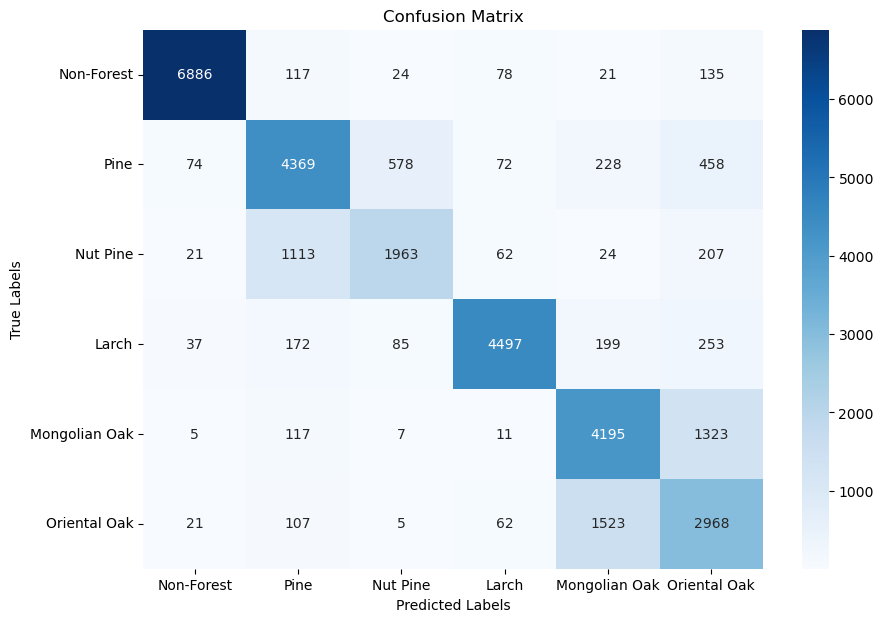

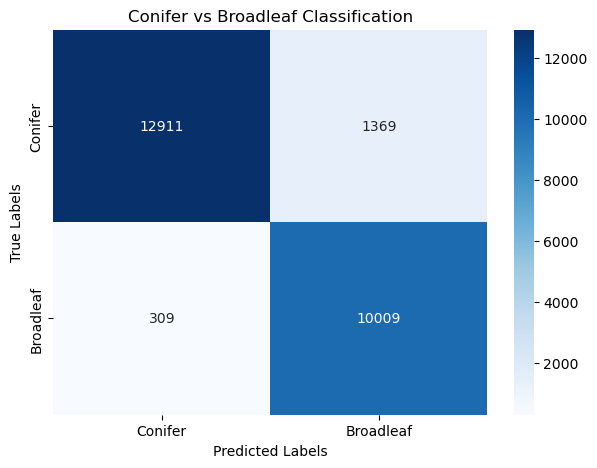

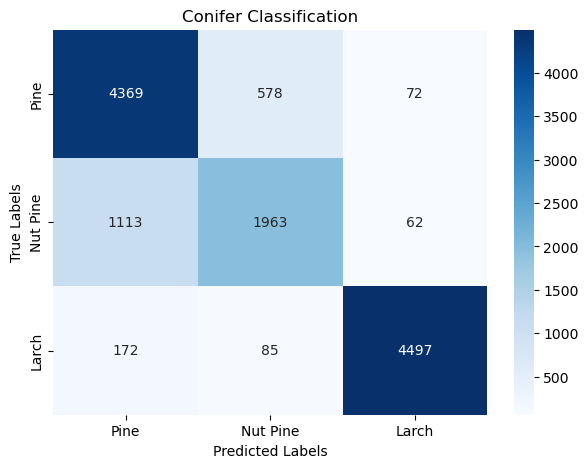

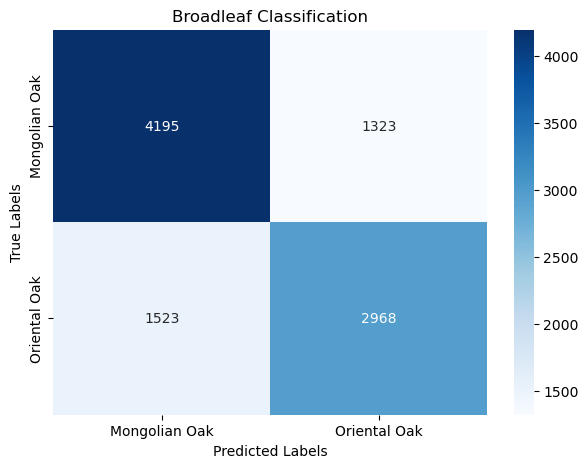

Finished Fold 4/5. Cleared memory.
4 start!


Epoch 1/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 147.93it/s]



Epoch [1/100], Train Loss: 75.0588, Train Accuracy: 67.81%, Val Loss: 82.8428, Val Accuracy: 70.70%



Epoch 2/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 147.43it/s]



Epoch [2/100], Train Loss: 66.2155, Train Accuracy: 72.76%, Val Loss: 48.1325, Val Accuracy: 78.00%



Epoch 3/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 146.68it/s]



Epoch [3/100], Train Loss: 65.9297, Train Accuracy: 73.98%, Val Loss: 70.3821, Val Accuracy: 75.34%



Epoch 4/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 146.75it/s]



Epoch [4/100], Train Loss: 65.1766, Train Accuracy: 74.71%, Val Loss: 95.2026, Val Accuracy: 72.56%



Epoch 5/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 147.66it/s]



Epoch [5/100], Train Loss: 66.4462, Train Accuracy: 75.05%, Val Loss: 137.4417, Val Accuracy: 66.82%



Epoch 6/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 146.80it/s]



Epoch [6/100], Train Loss: 66.5154, Train Accuracy: 75.49%, Val Loss: 93.2348, Val Accuracy: 71.72%



Epoch 7/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 149.80it/s]



Epoch [7/100], Train Loss: 66.5796, Train Accuracy: 75.79%, Val Loss: 136.9609, Val Accuracy: 65.32%



Epoch 8/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 148.46it/s]



Epoch [8/100], Train Loss: 66.5205, Train Accuracy: 75.94%, Val Loss: 59.8541, Val Accuracy: 79.39%



Epoch 9/100 - Validation: 100%|█████████████████████████████| 937/937 [00:06<00:00, 143.28it/s]



Epoch [9/100], Train Loss: 70.9171, Train Accuracy: 75.58%, Val Loss: 151.7355, Val Accuracy: 66.94%



Epoch 10/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.02it/s]



Epoch [10/100], Train Loss: 68.0987, Train Accuracy: 76.21%, Val Loss: 70.4655, Val Accuracy: 76.49%



Epoch 11/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.46it/s]



Epoch [11/100], Train Loss: 64.7763, Train Accuracy: 76.77%, Val Loss: 82.7548, Val Accuracy: 72.62%



Epoch 12/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 145.95it/s]



Epoch [12/100], Train Loss: 67.4246, Train Accuracy: 76.33%, Val Loss: 74.6782, Val Accuracy: 78.76%



Epoch 13/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.94it/s]



Epoch [13/100], Train Loss: 68.9562, Train Accuracy: 76.67%, Val Loss: 68.7059, Val Accuracy: 75.81%



Epoch 14/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.38it/s]



Epoch [14/100], Train Loss: 63.8848, Train Accuracy: 77.01%, Val Loss: 83.6587, Val Accuracy: 74.56%



Epoch 15/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.22it/s]



Epoch [15/100], Train Loss: 68.2083, Train Accuracy: 76.61%, Val Loss: 89.5588, Val Accuracy: 75.96%



Epoch 16/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.83it/s]



Epoch [16/100], Train Loss: 65.4095, Train Accuracy: 77.06%, Val Loss: 79.9920, Val Accuracy: 76.34%



Epoch 17/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.23it/s]



Epoch [17/100], Train Loss: 66.3867, Train Accuracy: 77.07%, Val Loss: 60.3235, Val Accuracy: 80.23%



Epoch 18/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.21it/s]



Epoch [18/100], Train Loss: 65.0408, Train Accuracy: 77.27%, Val Loss: 85.5582, Val Accuracy: 73.53%



Epoch 19/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 148.05it/s]



Epoch [19/100], Train Loss: 65.5742, Train Accuracy: 77.32%, Val Loss: 137.0199, Val Accuracy: 73.52%



Epoch 20/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.61it/s]



Epoch [20/100], Train Loss: 65.1865, Train Accuracy: 77.42%, Val Loss: 73.8821, Val Accuracy: 77.68%



Epoch 21/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 147.43it/s]



Epoch [21/100], Train Loss: 66.9560, Train Accuracy: 77.46%, Val Loss: 59.5571, Val Accuracy: 80.02%



Epoch 22/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 149.82it/s]



Epoch [22/100], Train Loss: 62.5420, Train Accuracy: 77.92%, Val Loss: 91.8736, Val Accuracy: 73.40%



Epoch 23/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.99it/s]



Epoch [23/100], Train Loss: 63.9909, Train Accuracy: 77.77%, Val Loss: 88.1705, Val Accuracy: 75.33%



Epoch 24/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.33it/s]



Epoch [24/100], Train Loss: 62.4956, Train Accuracy: 78.05%, Val Loss: 56.5368, Val Accuracy: 79.01%



Epoch 25/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.73it/s]



Epoch [25/100], Train Loss: 64.0887, Train Accuracy: 77.90%, Val Loss: 81.5724, Val Accuracy: 76.46%



Epoch 26/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 145.91it/s]



Epoch [26/100], Train Loss: 61.3327, Train Accuracy: 78.21%, Val Loss: 70.4750, Val Accuracy: 78.77%



Epoch 27/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 145.55it/s]



Epoch [27/100], Train Loss: 63.4182, Train Accuracy: 77.99%, Val Loss: 77.6164, Val Accuracy: 75.69%



Epoch 28/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 148.65it/s]



Epoch [28/100], Train Loss: 62.9243, Train Accuracy: 78.38%, Val Loss: 72.6680, Val Accuracy: 78.11%



Epoch 29/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 148.14it/s]



Epoch [29/100], Train Loss: 65.4244, Train Accuracy: 78.12%, Val Loss: 93.4808, Val Accuracy: 72.72%



Epoch 30/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 150.41it/s]



Epoch [30/100], Train Loss: 61.1991, Train Accuracy: 78.54%, Val Loss: 73.0929, Val Accuracy: 78.79%



Epoch 31/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.52it/s]



Epoch [31/100], Train Loss: 62.2045, Train Accuracy: 78.64%, Val Loss: 92.2121, Val Accuracy: 76.12%



Epoch 32/100 - Validation: 100%|████████████████████████████| 937/937 [00:06<00:00, 146.22it/s]



Epoch [32/100], Train Loss: 60.8916, Train Accuracy: 78.84%, Val Loss: 111.4903, Val Accuracy: 72.91%

Early stopping triggered. Training stopped.


Evaluation Progress: 100%|██████████████████████████████████| 937/937 [00:06<00:00, 147.74it/s]


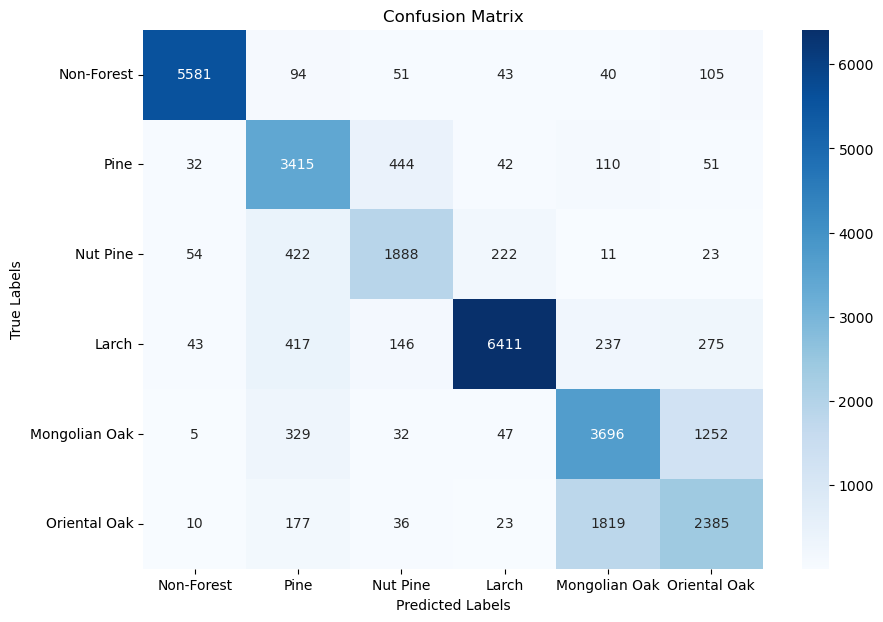

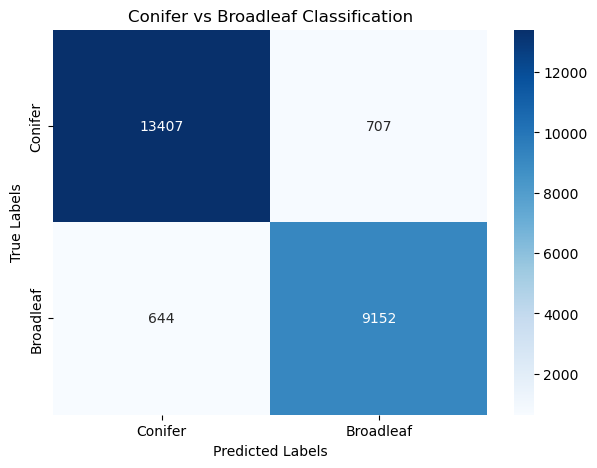

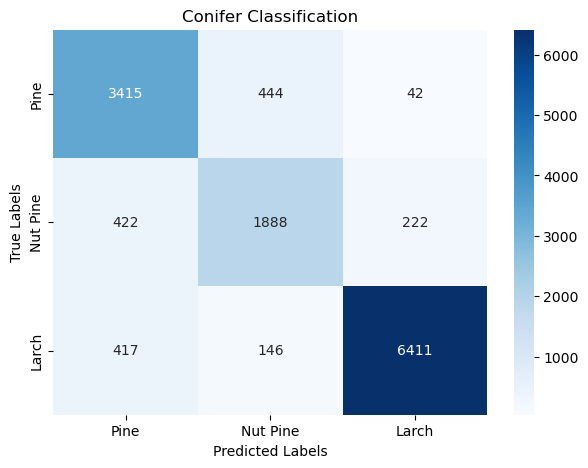

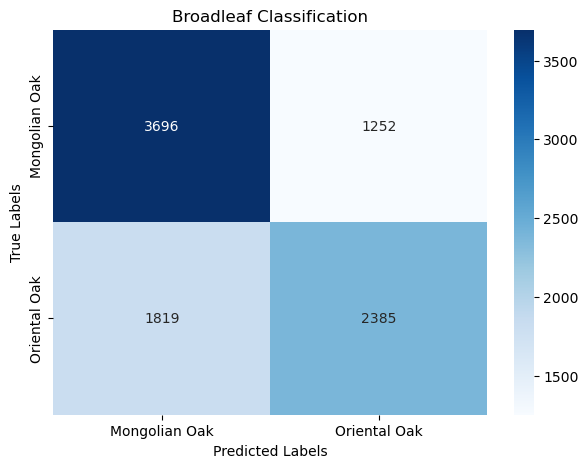

Finished Fold 5/5. Cleared memory.
CSV 파일이 저장되었습니다: ./results/dnn_274700.csv


In [6]:
num_epochs = 100
bands = 4 #밴드 수
patch_size = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("./checkpoints/dnn", exist_ok=True)

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 9, 9).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

large_tif_dir = '../../data/source_data/naive' #원천데이터 주소

transform = get_transform(bands, scale_channels)


def main():

    val_filters = [
        lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49} ,
        lambda x: x >= 2 and (x % 50) in {2, 7, 14, 19, 21, 26, 33, 38, 45, 0}  ,
        lambda x: x >= 3 and (x % 50) in {3, 8, 15, 20, 22, 27, 34, 39, 41, 46},
        lambda x: x >= 4 and (x % 50) in {4, 9, 11, 16, 23, 28, 35, 40, 42, 47 }  ,
        lambda x: x >= 5 and (x % 50) in {5, 10, 12, 17, 24, 29, 31, 36, 43, 48},
    ]
    
    os.makedirs("./checkpoints/hybrid", exist_ok=True)
    
    result_df = {} #반환하는 데이터 프레임을 딕셔너리로 만들기
    
    for idx, val_filter in enumerate(val_filters):
        
        print(f"{idx} start!")
        
        train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

        val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model = SmallDNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        
        best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=30)
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, f"./checkpoints/dnn/dnn_{bands}_{patch_size}_{num_epochs}_{idx}.pth")
        
        #결과 딕셔너리에 추가
        result_df[idx] = evaluate_model_with_cm(model, val_loader, num_classes=6)
        
        # ✅ 메모리 정리
        del model, train_loader, val_loader, optimizer, criterion
        torch.cuda.empty_cache()
        print(f"Finished Fold {idx+1}/{len(val_filters)}. Cleared memory.")
        
    # 결과 저장 경로 설정
    save_path = "./results/dnn_274700.csv"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 모든 데이터프레임을 하나로 합치기
    dfs = []
    for key, df in result_df.items():
        df = df.copy()
        df["dataset"] = key  # 데이터셋 열 추가
        df = df.reset_index().rename(columns={"index": "class"})
        dfs.append(df)

    # 데이터프레임 병합
    final_df = pd.concat(dfs, ignore_index=True)

    # CSV 저장
    final_df.to_csv(save_path, encoding="utf-8-sig", index=False)

    print(f"CSV 파일이 저장되었습니다: {save_path}")

if __name__ == "__main__":
    main()
